In [2]:
import time as time
import math

import numpy as np
import matplotlib.pyplot as plt 
import scipy.linalg as sclin

from numba import njit
from numba.typed import Dict
from numba.core import types

from pocs.File_manage import read_write as rw 

In [4]:
plot_dir    = "plots/"
data_dir    = "data/" 

## Chemical Master equation 
P(m,p) = 
+alphaR( P(m-1,p) - P(m,p) ) 
+alphaP( P(m,p-1) - P(m,p) )
+dR[ (m+1)P(m+1,p) - mP(m,p) ]
+dP[ (p+1)P(m,p+1) - pP(m,p) ]




In [7]:
if False: 
    para_list = [20, 2.5, 10]

    pmax = 199
    mmax = 9
    mat_len = (pmax+1) * (mmax + 1)
    M = np.zeros((mat_len, mat_len), dtype=float)
    I = np.zeros((mat_len, mat_len), dtype=float)
    for i in range(mat_len):
        I[i][i] = 1 
    # 


    M = fill_matrix_FB(mat_len, pmax, mmax, M, *para_list)
    M = matrixNormalization(mat_len, M)

    eig_val, eig_vec = np.linalg.eig(M)
    arg_sort_eig = eig_val.argsort()
    arg_sort_eig = np.flip(arg_sort_eig)

    prob_eq = np.zeros(( mmax+1, pmax+1))
    for idx, eig_idx in enumerate(arg_sort_eig[:20]):
        max_vec = eig_vec[:,eig_idx]
        eig_value = eig_val[eig_idx]

        vec_norm = sum(max_vec)
        for i in range(len(max_vec)): 
            m = i // (pmax + 1)
            p = i % (pmax + 1)
            
            prob_eq[m,p] = max_vec[i]/vec_norm
        # 

        plt.title(f"Lambda = {-round(eig_value,4)}, \n alpha {para_list[0]} beta {para_list[1]} gamma {para_list[2]}")
        plt.xlabel("Protein #")
        plt.ylabel("mRNA #")
        plt.imshow(prob_eq, aspect=10, origin="lower")
        plt.colorbar()
        plt.savefig(plot_dir +f"Sol_P_lambda{idx:03d}.png", dpi = 300)
        plt.clf()
        
        plt.plot(sum(prob_eq.T), marker="o")
        plt.grid()
        plt.title(f"mRNA Lambda = {-round(eig_value,4)}, \n alpha {para_list[0]} beta {para_list[1]} gamma {para_list[2]}")
        plt.savefig(plot_dir + f"Sol_P_lambda{idx:03d}_mRNA.png", dpi = 300)
        plt.clf()
        
        plt.plot(sum(prob_eq), marker="o")
        plt.grid()
        plt.title(f"Protien Lambda = {-round(eig_value,4)}, \n alpha {para_list[0]} beta {para_list[1]} gamma {para_list[2]}")
        plt.savefig(plot_dir + f"Sol_P_lambda{idx:03d}_Protein.png", dpi = 300)
        plt.clf()
        
        
        
    rw.pickle_dump(data_dir, f"p_{pmax}_m_{mmax}_para_{para_list[0]}_{para_list[1]}_{para_list[2]}_eig.bin", eig_val[0])
    rw.pickle_dump(data_dir, f"p_{pmax}_m_{mmax}_para_{para_list[0]}_{para_list[1]}_{para_list[2]}_vec.bin", eig_vec[1])


In [8]:
from functools import lru_cache
import numpy.linalg as nplin

def get_coef_vec(eig_vec, init_vec):
    X = nplin.inv(eig_vec).dot(init_vec)
    return X 
#

class Transition_Matrix():
    def __init__(self, t_mat):
        self.t_mat = t_mat
        return
    
    def get_coef_vec(self, init_vec):
        X = nplin.inv(self.eig_vec).dot(init_vec)
        return X 
    #
    
    @lru_cache(5)
    def update_eigens(self):
        self.eig_val, self.eig_vec = nplin.eig(self.t_mat)
    #
    
    def get_eigens(self): 
        return nplin.eig(self.t_mat)
    #
    
    def get_state_t(self, t, init_vec):
        self.update_eigens()
        coef_vec = self.get_coef_vec(init_vec)
        val = 0
        for idx, ci in enumerate(coef_vec): 
            val += ci * self.eig_vec[:,idx] * np.exp( self.eig_val[idx]*t )
        #
        return val 
    # 
# 

/home/jhchae/miniconda3/envs/jh/lib/python3.7/site-packages/ipykernel_launcher.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


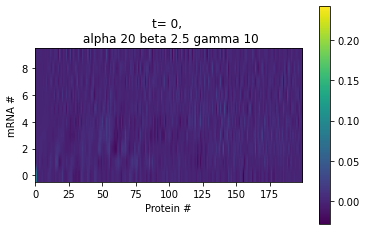

In [9]:
para_list = [20, 2.5, 10]

pmax = 199
mmax = 9
mat_len = (pmax+1) * (mmax + 1)
M = np.zeros((mat_len, mat_len), dtype=float)
I = np.zeros((mat_len, mat_len), dtype=float)
for i in range(mat_len):
    I[i][i] = 1 
# 
M = fill_matrix_FB(mat_len, pmax, mmax, M, *para_list)
M = matrixNormalization(mat_len, M)

prob_eq = np.zeros(( mmax+1, pmax+1))

mat = Transition_Matrix(M)
max_vec = mat.get_state_t(0, [1.0] + [0.0 for _ in range(mat_len - 1)])
    
vec_norm = sum(max_vec)
for i in range(len(max_vec)): 
    m = i // (pmax + 1)
    p = i % (pmax + 1)
    
    prob_eq[m,p] = max_vec[i]/vec_norm
# 
plt.xlabel("A")
plt.ylabel("B")


plt.title(f"t= {round(0,4)}, \n alpha {para_list[0]} beta {para_list[1]} gamma {para_list[2]}")
plt.xlabel("Protein #")
plt.ylabel("mRNA #")
plt.imshow(prob_eq, aspect=10, origin="lower")
plt.colorbar()

[ 1.00883774-0.00034601j  0.00207023-0.00179679j -0.00451678-0.00182075j
 ... -0.01224894-0.00399154j -0.00366916+0.01765584j
  0.0176652 -0.00483511j]


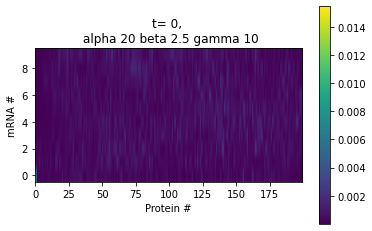

In [10]:
eig_val, eig_vec = nplin.eig(M)
init = [1.0] + [0.0 for _ in range(mat_len - 1)]
#print(init)

X = nplin.inv(eig_vec).dot(init)
val = 0
for idx, ci in enumerate(X): 
    val += ci * eig_vec[:,idx] * np.exp( 0 )
#
print(val)
max_vec = np.abs(val)
vec_norm = sum(max_vec)
for i in range(len(max_vec)): 
    m = i // (pmax + 1)
    p = i % (pmax + 1)
    
    prob_eq[m,p] = max_vec[i]/vec_norm
# 
plt.xlabel("A")
plt.ylabel("B")


plt.title(f"t= {round(0,4)}, \n alpha {para_list[0]} beta {para_list[1]} gamma {para_list[2]}")
plt.xlabel("Protein #")
plt.ylabel("mRNA #")
plt.imshow(prob_eq, aspect=10, origin="lower")
plt.colorbar()
    

In [11]:
sum(val)

(4.178114476748818+0.01337613346205464j)

0.0


/home/jhchae/miniconda3/envs/jh/lib/python3.7/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


0.0
0.0125
0.025
0.037500000000000006
0.05
0.0625
0.07500000000000001
0.08750000000000001
0.1
0.1125
0.125
0.1375
0.15000000000000002
0.1625
0.17500000000000002
0.1875
0.2
0.21250000000000002
0.225
0.23750000000000002
0.25
0.2625
0.275
0.28750000000000003
0.30000000000000004
0.3125
0.325
0.3375
0.35000000000000003
0.36250000000000004
0.375
0.3875
0.4
0.41250000000000003
0.42500000000000004
0.4375
0.45
0.4625
0.47500000000000003
0.48750000000000004
0.5
0.5125000000000001
0.525
0.5375
0.55
0.5625
0.5750000000000001
0.5875
0.6000000000000001
0.6125
0.625
0.6375000000000001
0.65
0.6625000000000001
0.675
0.6875
0.7000000000000001
0.7125
0.7250000000000001
0.7375
0.75
0.7625000000000001
0.775
0.7875000000000001
0.8
0.8125
0.8250000000000001
0.8375
0.8500000000000001
0.8625
0.875
0.8875000000000001
0.9
0.9125000000000001
0.925
0.9375
0.9500000000000001
0.9625
0.9750000000000001
0.9875
1.0


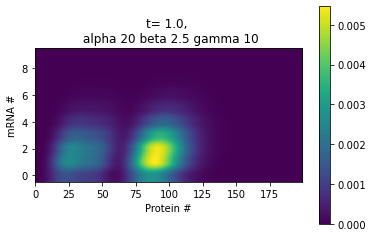

In [12]:
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
img = [] # some array of images
frames = [] # for storing the generated images
fig = plt.figure()

para_list = [20, 2.5, 10]

pmax = 199
mmax = 9
mat_len = (pmax+1) * (mmax + 1)
M = np.zeros((mat_len, mat_len), dtype=float)
I = np.zeros((mat_len, mat_len), dtype=float)
for i in range(mat_len):
    I[i][i] = 1 
# 


M = fill_matrix_FB(mat_len, pmax, mmax, M, *para_list)
M = matrixNormalization(mat_len, M)

mat = Transition_Matrix(M)

prob_eq = np.zeros(( mmax+1, pmax+1))

def update(frame):
    fig.clear()
    t = frame 
    print(t)
    max_vec = mat.get_state_t(t, [0.5,0.5] + [0.0 for _ in range(mat_len - 2)])
    
    vec_norm = sum(max_vec)
    for i in range(len(max_vec)): 
        m = i // (pmax + 1)
        p = i % (pmax + 1)
        
        prob_eq[m,p] = max_vec[i]/vec_norm
    # 
    plt.xlabel("A")
    plt.ylabel("B")
    
    
    plt.title(f"t= {round(frame,4)}, \n alpha {para_list[0]} beta {para_list[1]} gamma {para_list[2]}")
    plt.xlabel("Protein #")
    plt.ylabel("mRNA #")
    plt.imshow(prob_eq, aspect=10, origin="lower")
    plt.colorbar()
    
writer=FFMpegWriter(bitrate=500)
ani = FuncAnimation(fig, update, frames = np.linspace(0,1,81))
ani.save("Solution_slow.avi", dpi=300, writer=writer)


In [13]:
def update(frame):
    fig.clear()
    t = frame 
    print(t)
    max_vec = mat.get_state_t(t, [1.0] + [0.0 for _ in range(mat_len - 1)])
    
    vec_norm = sum(max_vec)
    for i in range(len(max_vec)): 
        m = i // (pmax + 1)
        p = i % (pmax + 1)
        
        prob_eq[m,p] = max_vec[i]/vec_norm
    # 
    plt.xlabel("A")
    plt.ylabel("B")
    
    
    plt.title(f"t= {round(frame,4)}, \n alpha {para_list[0]} beta {para_list[1]} gamma {para_list[2]}")
    plt.xlabel("Protein #")
    plt.ylabel("mRNA #")
    plt.imshow(prob_eq, aspect=10, origin="lower")
    plt.colorbar()